In [2]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

Генератор последовательности рукописных символов

In [3]:
class HandwrittenSymbolsGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self._load_symbols()
    
    def _load_symbols(self):
        folders = [f for f in os.listdir(self.data_path) 
                  if os.path.isdir(os.path.join(self.data_path, f))]
        
        total_images = 0
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []
            
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)
            
            self.symbols_data[folder] = images
            total_images += len(images)
    
    def generate_sequence(self, length=10):
        symbols = list(self.symbols_data.keys())
        sequence_images = []
        labels = []
        
        print(f"Генерация последовательности из {length} символов...")
        
        for i in range(length):
            symbol = random.choice(symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = cv2.imread(image_path)
            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)
        
        sequence_image = self.create_sequence_image(sequence_images)
        
        print(f"Сгенерировано: {' '.join(labels)}")
        
        return {
            'sequence_images': sequence_images,  # список отдельных изображений
            'sequence_image': sequence_image,    # объединенное изображение
            'labels': labels,                    # список меток символов
            'sequence_text': ''.join(labels),    # строка последовательности
            'length': length
        }
    
    def generate_multiple_sequences(self, num_sequences=5, length=10):
        sequences = []
        for i in range(num_sequences):
            print(f"\n--- Последовательность {i+1} ---")
            seq_data = self.generate_sequence(length)
            sequences.append(seq_data)
        return sequences

    def create_sequence_image(self, images, spacing=20):
        processed_images = []
        for img in images:
            if len(img.shape) == 3:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                processed_images.append(gray_img)
            else:
                processed_images.append(img)

        total_width = sum(img.shape[1] for img in processed_images) + spacing * (len(processed_images) - 1)
        max_height = max(img.shape[0] for img in processed_images)
        
        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in processed_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + spacing
        
        return sequence_img
    
    def display_sequence(self, sequence_data, title="Сгенерированная последовательность"):
        plt.figure(figsize=(12, 3))
        plt.imshow(sequence_data['sequence_image'], cmap='gray')
        plt.title(f"{title}: {sequence_data['sequence_text']}")
        plt.axis('off')
        plt.show()

DATA_PATH = 'C:\\Users\\rabat\\Desktop\\image_processing\\hw9\\datas\\data'

print("Загрузка данных символов...")
generator = HandwrittenSymbolsGenerator(DATA_PATH)

Загрузка данных символов...


Случайная последовательность:
Генерация последовательности из 10 символов...
Сгенерировано: 4 3 t 0 , ( t ( 4 times


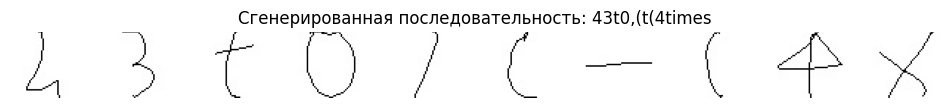

In [4]:
print("Случайная последовательность:")
sequence_data = generator.generate_sequence(length=10)
generator.display_sequence(sequence_data)

Выделение объектов

In [5]:
class SequenceSegmenter:
    def segment_sequence(self, sequence_image, original_labels):
        print(f"Обрабатываем последовательность: {' '.join(original_labels)}")
        
        non_space_labels = [label for label in original_labels if label != ' ']
        print(f"Символы без пробелов: {non_space_labels}")

        img_gray = sequence_image
        kernel = np.ones((3,3),np.uint8)
        img_gray = cv2.erode(img_gray,kernel,iterations = 1)
        img_gray = cv2.bitwise_not(img_gray)
        
        base_size = img_gray.shape[0], img_gray.shape[1]
        base = np.zeros(base_size, dtype=np.uint8)
        base[0:img_gray.shape[0], 0:img_gray.shape[1]] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

        plt.figure(figsize=(10, 3))
        plt.imshow(base)
        plt.title(f'Последовательность: {" ".join(original_labels)}')
        plt.axis('off')
        plt.show()

        ret, thresh = cv2.threshold(base, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
        
        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = base.copy()

        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i] 
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Обнаруженные контуры символов')
        plt.axis('off')
        plt.show()

        sequence_symbols = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]
            
            img_crop = sequence_image[y:y+h, x:x+w]
            
            if i < len(non_space_labels):
                symbol_label = non_space_labels[i]
            else:
                symbol_label = "?"
                
            plt.figure(figsize=(3, 2))
            plt.imshow(img_crop, cmap="gray")
            plt.title(f'Символ {i+1}: "{symbol_label}"')
            plt.axis('off')
            plt.show()
            
            sequence_symbols.append((symbol_label, img_crop))
            print(f"Символ {i+1}: '{symbol_label}' ")

        return sequence_symbols

Генерация последовательности из 10 символов...
Сгенерировано: t 4 1 y + times ) 8 - t
Обрабатываем последовательность: t 4 1 y + times ) 8 - t
Символы без пробелов: ['t', '4', '1', 'y', '+', 'times', ')', '8', '-', 't']


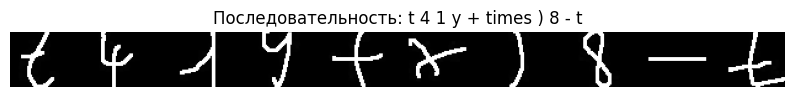

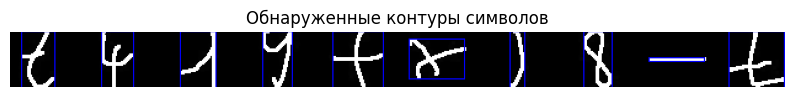

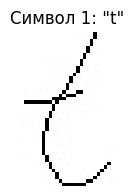

Символ 1: 't' 


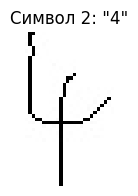

Символ 2: '4' 


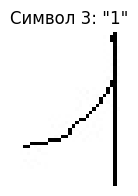

Символ 3: '1' 


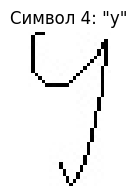

Символ 4: 'y' 


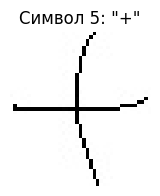

Символ 5: '+' 


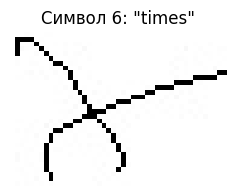

Символ 6: 'times' 


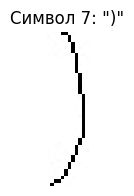

Символ 7: ')' 


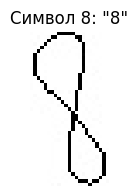

Символ 8: '8' 


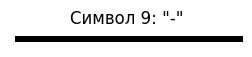

Символ 9: '-' 


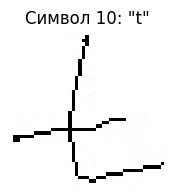

Символ 10: 't' 
Итог: сегментировано 10 символов


In [6]:
sequence_data = generator.generate_sequence(length=10)
sequence_image = sequence_data['sequence_image']
labels = sequence_data['labels']

segmenter = SequenceSegmenter()
segmented_symbols = segmenter.segment_sequence(sequence_image, labels)
print(f"Итог: сегментировано {len(segmented_symbols)} символов")

Тренировка модели kNN  


In [7]:
def center_in_45(image, target_size=45):
    h, w = image.shape
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

In [8]:
def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []
    
    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
  
        images = [f for f in os.listdir(symbol_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()
         
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        mapped_symbol = symbol
        
        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(mapped_symbol)
    
    return np.array(X_train), np.array(y_train)

In [9]:
symbols = ['0','1','2','3','4','5','6','7','8','9','+','-','times','t','X','y','w','h','(',')',',']
X_train, y_train = load_training_data('C:\\Users\\rabat\\Desktop\\image_processing\\hw9\\datas\\data', symbols, 0.8)
print(f"Обучающая выборка: {len(X_train)} изображений")

Обучающая выборка: 180225 изображений


In [10]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
print("Завершено успешно")

Завершено успешно


In [11]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
print("Завершено успешно")

Завершено успешно


In [12]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
print("Завершено успешно")

Завершено успешно


In [13]:
knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, y_train)
print("Завершено успешно")
print("Все модели успешно обучены!")

Завершено успешно
Все модели успешно обучены!


Применение kNN для решения задачи

Генерация последовательности из 10 символов...
Сгенерировано: 3 ) 8 X 8 t 7 ( X X


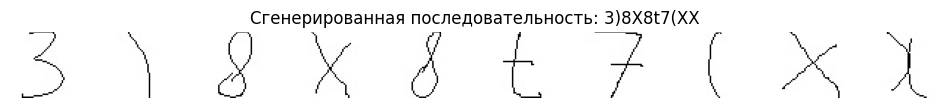

Обрабатываем последовательность: 3 ) 8 X 8 t 7 ( X X
Символы без пробелов: ['3', ')', '8', 'X', '8', 't', '7', '(', 'X', 'X']


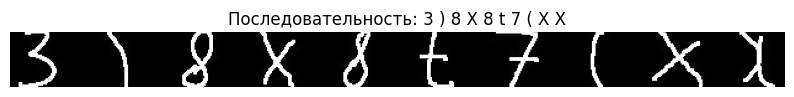

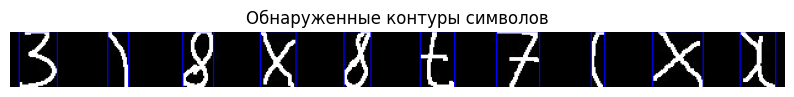

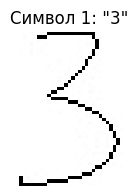

Символ 1: '3' 


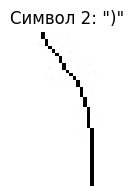

Символ 2: ')' 


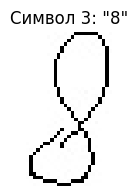

Символ 3: '8' 


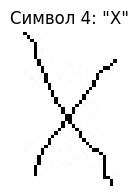

Символ 4: 'X' 


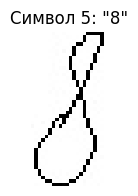

Символ 5: '8' 


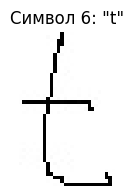

Символ 6: 't' 


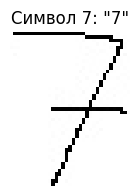

Символ 7: '7' 


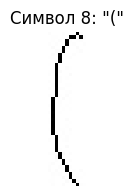

Символ 8: '(' 


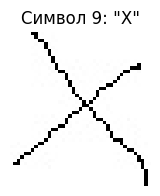

Символ 9: 'X' 


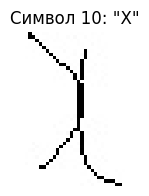

Символ 10: 'X' 


In [24]:
def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

sequence_data = generator.generate_sequence(length=10)
generator.display_sequence(sequence_data)

original_labels = sequence_data['labels']
sequence_image = sequence_data['sequence_image']

segmenter = SequenceSegmenter()
symbols_data = segmenter.segment_sequence(sequence_image, original_labels)


ОБРАБОТАННЫЕ СИМВОЛЫ:


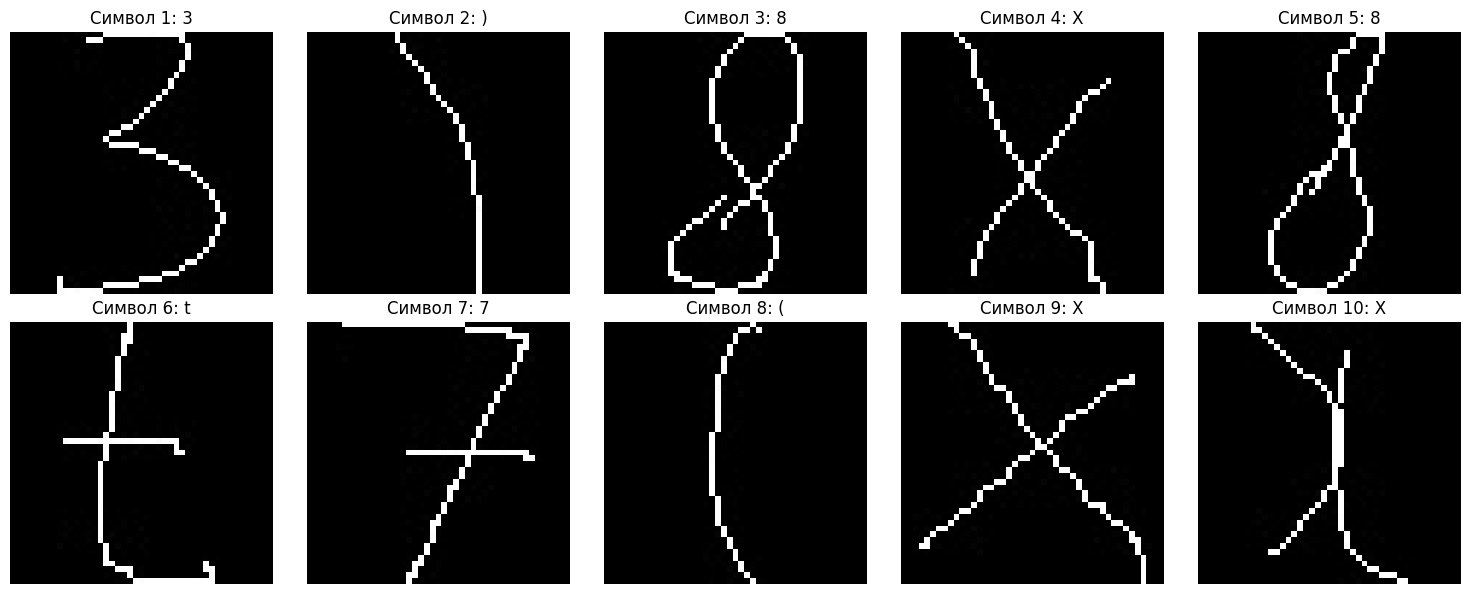


МОДЕЛЬ: knn1
    Символ 1: ожидалось '3', предсказан '3'
    Символ 2: ожидалось ')', предсказан ')'
    Символ 3: ожидалось '8', предсказан '8'
    Символ 4: ожидалось 'X', предсказан 'X'
    Символ 5: ожидалось '8', предсказан '8'
    Символ 6: ожидалось 't', предсказан 't'
    Символ 7: ожидалось '7', предсказан '7'
    Символ 8: ожидалось '(', предсказан '('
    Символ 9: ожидалось 'X', предсказан 'X'
    Символ 10: ожидалось 'X', предсказан 'X'
Предсказано: '3)8X8t7(XX'
Accuracy для knn1: 1.00 (10/10 символов)

МОДЕЛЬ: knn3
    Символ 1: ожидалось '3', предсказан '3'
    Символ 2: ожидалось ')', предсказан ')'
    Символ 3: ожидалось '8', предсказан '8'
    Символ 4: ожидалось 'X', предсказан 'X'
    Символ 5: ожидалось '8', предсказан '8'
    Символ 6: ожидалось 't', предсказан 't'
    Символ 7: ожидалось '7', предсказан '7'
    Символ 8: ожидалось '(', предсказан '('
    Символ 9: ожидалось 'X', предсказан 'X'
    Символ 10: ожидалось 'X', предсказан 'X'
Предсказано: '3)8X8t7(X

In [25]:
resized_symbols = []
for true_label, symbol_img in symbols_data:
    processed_img = cv2.bitwise_not(symbol_img)
    resized_img = center_in_45(processed_img)
    resized_symbols.append((true_label, resized_img))
symbols_data = resized_symbols

print("\nОБРАБОТАННЫЕ СИМВОЛЫ:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for j, (true_label, symbol_img) in enumerate(symbols_data):
    if j < 10:
        axes[j].imshow(symbol_img, cmap='gray')
        axes[j].set_title(f'Символ {j+1}: {true_label}')
        axes[j].axis('off')

plt.tight_layout()
plt.show()

models = {
    'knn1': knn1,
    'knn3': knn3, 
    'knn5': knn5,
    'knn7': knn7
}

results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    predicted_symbols = []
    
    for j, (true_label, symbol_img) in enumerate(symbols_data):
        img_flat = symbol_img.flatten()
        predicted_char = model.predict([img_flat])[0]
        predicted_symbols.append(predicted_char)
        print(f"    Символ {j+1}: ожидалось '{true_label}', предсказан '{predicted_char}'")
    
    predicted_text = ''.join(predicted_symbols)
    print(f"Предсказано: '{predicted_text}'")
    
    original_text_str = sequence_data['sequence_text']
    
    correct_chars = sum(1 for orig, pred in zip(original_text_str, predicted_text) if orig == pred)
    total_chars = len(original_text_str)
    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    
    if original_text_str != predicted_text:
        for idx, (orig_char, pred_char) in enumerate(zip(original_text_str, predicted_text)):
            if orig_char != pred_char:
                print(f"   Ошибка в позиции {idx+1}: ожидалось '{orig_char}', получено '{pred_char}'")
    
    print(f"Accuracy для {model_name}: {accuracy:.2f} ({correct_chars}/{total_chars} символов)")
    
    results[model_name] = {
        'predicted_text': predicted_text,
        'accuracy': accuracy,
        'correct_chars': correct_chars,
        'total_chars': total_chars
    }

print(f"\n{'='*60}")
print("ИТОГИ ПО ВСЕМ МОДЕЛЯМ:")
print(f"{'='*60}")

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    accuracy_percent = result['accuracy'] * 100
    print(f"{model_name:5} | Accuracy: {accuracy_percent:6.2f}% | {result['correct_chars']}/{result['total_chars']} | Предсказание: '{result['predicted_text']}'")